In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

from shapkit.shapley_values import ShapleyValues
from shapkit.inspector import inspector
from shapkit.monte_carlo_shapley import MonteCarloShapley
from shapkit.sgd_shapley import SGDshapley

%load_ext autoreload
%autoreload 2

# Load dataset

In [2]:
digits = datasets.load_digits()
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))
columns = ["pixel"+str(i) for i in range(data.shape[1])]
X = pd.DataFrame(data, columns=columns)
y = digits.target
X.head(5)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


In [3]:
# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)


# Train a ML model

In [4]:
classifier = svm.SVC(gamma=0.001)
classifier.fit(X_train, y_train)
predicted = classifier.predict(X_test)
print("Classification report for classifier %s:\n%s\n" % (classifier, metrics.classification_report(y_test, predicted)))

Classification report for classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        43
           1       0.98      1.00      0.99        46
           2       1.00      1.00      1.00        43
           3       0.98      0.85      0.91        47
           4       0.98      0.94      0.96        48
           5       0.94      0.98      0.96        45
           6       0.98      1.00      0.99        47
           7       0.98      1.00      0.99        45
           8       0.89      0.98      0.93        41
           9       0.96      0.96      0.96        45

    accuracy                           0.97       450
   macro avg       0.97      0.97      0.97       450
weighted avg       0.97     

# Define the game

In [5]:
d = X_train.shape[1]
n = 2**d - 2
d, n

(64, 18446744073709551614)

In [6]:
fc = lambda x: classifier.predict(x.reshape(1,-1))[0]

In [7]:
r_class, x_class = 0, 0
while x_class == r_class:
    idx_r, idx_x = np.random.choice(np.arange(len(X_test)), size=2, replace=False)
    r = X_test.iloc[idx_r,:]
    x = X_test.iloc[idx_x,:]
    r_class = fc(r.values)
    x_class = fc(x.values)
fc_class = lambda x: 1 if int(fc(x)) == int(x_class) else 0

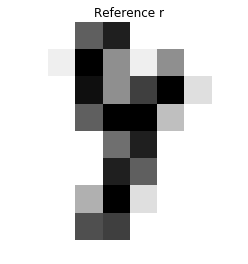

In [8]:
plt.figure()
ax = plt.imshow(r.values.reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
ax.axes.set_axis_off()
plt.title("Reference r")
plt.show()

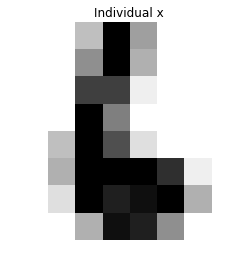

In [9]:
plt.figure()
ax = plt.imshow(x.values.reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
ax.axes.set_axis_off()
plt.title("Individual x")
plt.show()

# Approximation methods

## Monte Carlo 

In [10]:
mc_shap = MonteCarloShapley(x=x, fc=fc_class, ref=r, n_iter=1000)
mc_shap

  0%|          | 2/1000 [00:00<00:59, 16.64it/s]

new dimension 37


100%|██████████| 1000/1000 [00:34<00:00, 28.82it/s]


pixel0     0.000
pixel1     0.000
pixel2     0.014
pixel3    -0.003
pixel4     0.008
           ...  
pixel59   -0.005
pixel60    0.050
pixel61    0.026
pixel62    0.000
pixel63    0.000
Length: 64, dtype: float64

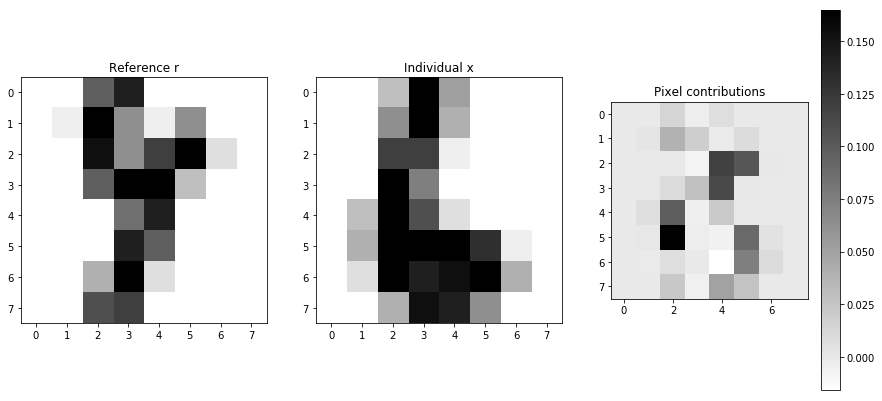

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15,7))
axes[0].imshow(r.values.reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
axes[0].set_title("Reference r")
axes[1].imshow(x.values.reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
axes[1].set_title("Individual x")
pc = axes[2].imshow(mc_shap.values.reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
axes[2].set_title("Pixel contributions")
cbar = fig.colorbar(pc)
plt.show()

## SGD

In [12]:
sgd_est = SGDshapley(d, C=y.max())
sgd_shap = sgd_est.sgd(x=x, fc=fc_class, ref=r, n_iter=10000, step=.1, step_type="sqrt")
sgd_shap

100%|██████████| 10000/10000 [00:06<00:00, 1597.81it/s]


pixel0     0.041006
pixel1    -0.014735
pixel2     0.013909
pixel3    -0.001684
pixel4    -0.009656
             ...   
pixel59    0.013039
pixel60    0.081011
pixel61    0.003105
pixel62    0.021644
pixel63   -0.024243
Length: 64, dtype: float64

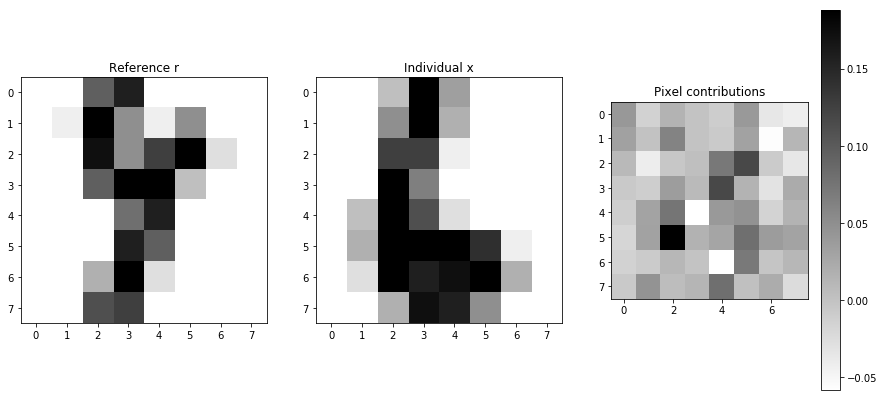

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15,7))
axes[0].imshow(r.values.reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
axes[0].set_title("Reference r")
axes[1].imshow(x.values.reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
axes[1].set_title("Individual x")
pc = axes[2].imshow(sgd_shap.values.reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
axes[2].set_title("Pixel contributions")
cbar = fig.colorbar(pc)
plt.show()